In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [2]:
# Load transformed data
cwd = os.getcwd()
datadir = cwd + os.sep + 'data' + os.sep
#datadir = '/'.join(cwd.split('/')) + '/Twitter-Bot-DSGA1001/data/'

def loadSentimentData(fileName):
    data = pd.read_csv(datadir + fileName, header=0, index_col=0)
    data.dropna(inplace=True)

    for each_col in data.columns:
        if each_col.find('_mv') > 0:
            data[each_col] = scale(data[each_col])
        
    data.drop(['arousal_mv','valence_mv'], 1, inplace=True)
    return data

def loadUserData(fileName):
    data = pd.read_csv(datadir + fileName, header=0, encoding="cp1252")
    data = data[['favourites_count','followers_count','friends_count','listed_count','statuses_count', 'label', 'default_profile', 'default_profile_image','verified']]
    return data

#data = loadSentimentData('sentiment_dist.csv')
data = loadUserData('varol-2017-users.csv')


# Feature Selection

In [3]:
# Train test split
sample_filt = np.random.uniform(0,1, data.shape[0]) > 0.8

X_train = data[sample_filt].drop('label',1)
Y_train = data[sample_filt].label
X_test = data[~sample_filt].drop('label',1)
Y_test = data[~sample_filt].label

In [4]:
# DecisionTree for MI scores
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

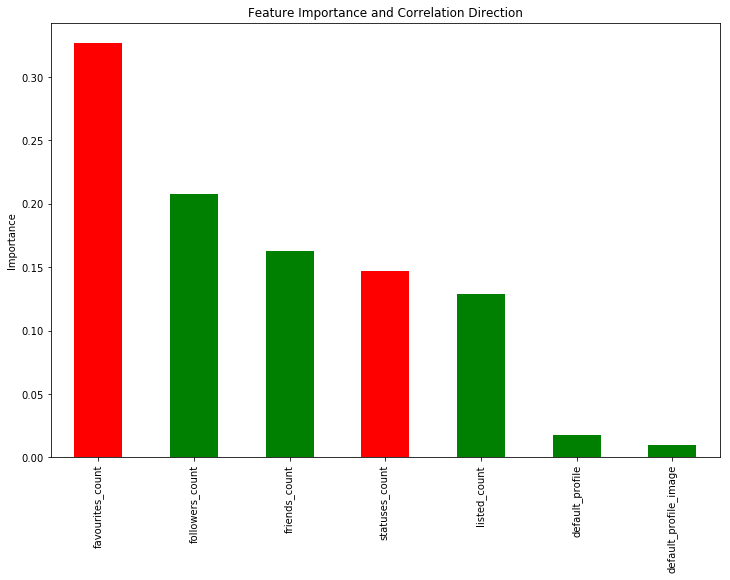

In [5]:
# Get importance and correlation
features_summary = pd.DataFrame(list(zip(X_train.columns, dt.feature_importances_)), 
                                columns=['feature','importance']).set_index('feature')
features_summary = features_summary.sort_values('importance', ascending=False)

corr_df = pd.DataFrame(data.corr()['label'][:-1])
corr_df.columns = ['correlation']

features_summary = features_summary.merge(corr_df, right_index=True, left_index=True)

# Plot importance and correlation
color_list = ['r' if corr < 0 else 'g' for corr in features_summary.correlation]
features_summary.importance.plot(kind='bar', color=color_list, figsize=(12,8))
plt.title('Feature Importance and Correlation Direction')
plt.ylabel('Importance')

# Select features
keep_features = features_summary[features_summary.importance > 0].index.values

# Train Baseline Model

In [6]:
# Discard features
X_train_filt = X_train[keep_features]
X_test_filt = X_test[keep_features]

In [7]:
# Baseline Logistic Regression and SVM
lr = LogisticRegression(C=1e30)
svm = SVC(kernel="linear")

kfold = KFold(10, True)
lr_cv = cross_val_score(lr, X_train_filt, Y_train, cv = kfold, scoring="roc_auc")
svm_cv = cross_val_score(svm, X_train_filt, Y_train, cv = kfold, scoring="roc_auc")

In [8]:
print("LR Mean CV AUC Score: {:0.3}".format(np.mean(lr_cv))+
      "\nLR StdErr CV AUC Score: {:0.3}".format(np.sqrt(np.var(lr_cv)/len(lr_cv)))
      )

print("\nSVM Mean CV AUC Score: {:0.3}".format(np.mean(svm_cv))+
      "\nSVM StdErr CV AUC Score: {:0.3}".format(np.sqrt(np.var(svm_cv)/len(svm_cv))))

LR Mean CV AUC Score: 0.772
LR StdErr CV AUC Score: 0.0306

SVM Mean CV AUC Score: 0.759
SVM StdErr CV AUC Score: 0.0313


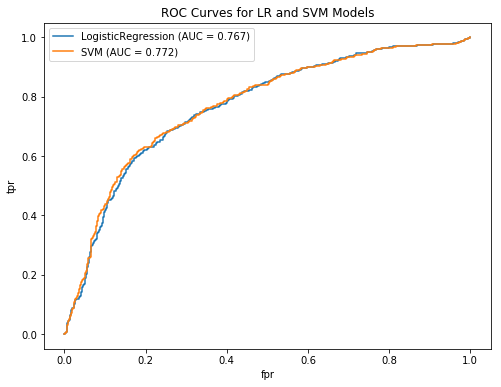

In [9]:
# ROC Curve for single train/test split baseline model
lr.fit(X_train_filt, Y_train)
svm.fit(X_train_filt, Y_train)

lr_pos_class = lr.classes_==1
preds_lr = lr.predict_proba(X_test_filt)[:,lr_pos_class]
preds_svm = svm.decision_function(X_test_filt)
preds_zip = zip([preds_lr, preds_svm], ["LogisticRegression", "SVM"])

fig, axes = plt.subplots(1,1, figsize=(8,6))
for each_preds, each_model in preds_zip:
    fpr, tpr, thresholds = roc_curve(Y_test, each_preds)
    roc_auc = auc(fpr, tpr)
    axes.plot(fpr, tpr, label = each_model+" (AUC = {:0.3})".format(roc_auc))

plt.title("ROC Curves for LR and SVM Models")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()